In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.io import wavfile
from scipy.stats.mstats import normaltest, skewtest, kurtosistest

## Import FastICA Algorithm

In [3]:
from parallel_ica import perform_fastica, inverse_fastica

## Functions from Demo

In [4]:
# Normalize audio amplitude between -0.5 and 0.5
def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

# Mix a matrix of samples using a random mixing matrix
def simpleMixer(S):
    np.random.seed(42)
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

# Plot the mixed signal with the mixing matrix
def drawDataWithMixingMatrix(data, mat, ground_truth=True):
    plt.figure(figsize=(8, 6))
    # plot data points
    plt.scatter(data[0], data[1], s=2, alpha = 0.6)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')
    if ground_truth:
        plt.title('Data with True Mixing Matrix', size = 18)
    else:
        plt.title('Data with Estimated Mixing Matrix', size = 18)
    
# Show mixed signal with true mixing matrix and estimated mixing matrix
def compareMixingMatrix(data, matA, matB):
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matB, ground_truth=False)

In [5]:
srate, bach_sample = wavfile.read('../data/bach.wav')
_, speech_sample = wavfile.read('../data/speech.wav')

## Check Gaussianity of Data

In [6]:
def check_gaussianity(X):
    # Perform D'Agostino and Pearson's test to determine normality
    # Combines skew and kurtosis for combined test of normality
    # k2 = s^2 + k^2 where s is skew and k is kurtosis
    test_result = normaltest(X)
    print('Normal Test p-value = {:0.4f}'.format(test_result.pvalue))
    
    # Calculate actual skew and kurtosis
    skew = skewtest(X).statistic
    kurtosis = kurtosistest(X).statistic
    
    # Find Gaussian and Laplacian Distributions of same length
    gaussian = np.random.randn(len(X))
    laplacian = np.random.laplace(size = len(X))
    
    # Interpret p-value
    if test_result.pvalue < 0.05:
        print('Reject Null Hypothesis that sample comes'
              ' from a normal distribution at alpha = 0.05')
    else:
        print('Fail to reject Null Hypothesis that sample'
              ' comes from a normal distribution at alpha= 0.05')
        
        
    print('\nSample Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skew, kurtosis))
    
    print('Gaussian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skewtest(gaussian).statistic, 
                                            kurtosistest(gaussian).statistic))
    print('Laplacian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}\n'.format(skewtest(laplacian).statistic, 
                                            kurtosistest(laplacian).statistic))
    
    
    plt.figure(figsize=(16, 8))
    
    # Plot sample distribution
    plt.subplot(131)
    sns.distplot(X, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Sample Distribution', size = 18);
    
    # Plot Gaussian Distribution of same length
    plt.subplot(132)
    sns.distplot(gaussian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Gaussian Distribution', size = 18);
    
    # Plot laplace
    plt.subplot(133)
    sns.distplot(laplacian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 18); plt.ylabel('Density', size = 18);
    plt.title('Laplacian Distribution', size = 18);
    
    plt.show();
    

## Test Check Gaussianity Function

Normal Test p-value = 0.6006
Fail to reject Null Hypothesis that sample comes from a normal distribution at alpha= 0.05

Sample Distribution Skew = 0.6927  Kurtosis = -0.7347
Gaussian Distribution Skew = 0.3933  Kurtosis = -0.1573
Laplacian Distribution Skew = 0.8726  Kurtosis = 95.0935



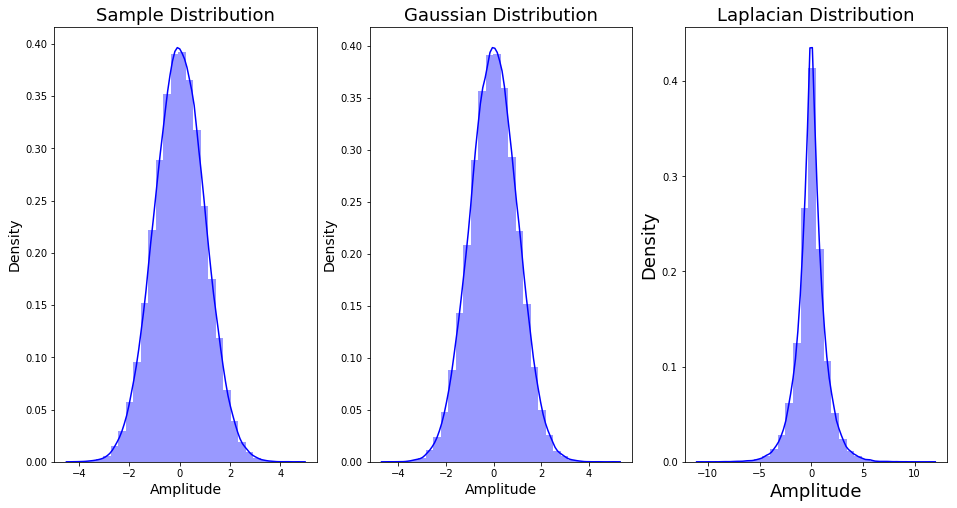

In [8]:
check_gaussianity(np.random.randn(len(bach_sample)))

## Test Bach Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = -9.9593  Kurtosis = 41.7558
Gaussian Distribution Skew = -1.9743  Kurtosis = -0.0560
Laplacian Distribution Skew = 1.0019  Kurtosis = 98.2441



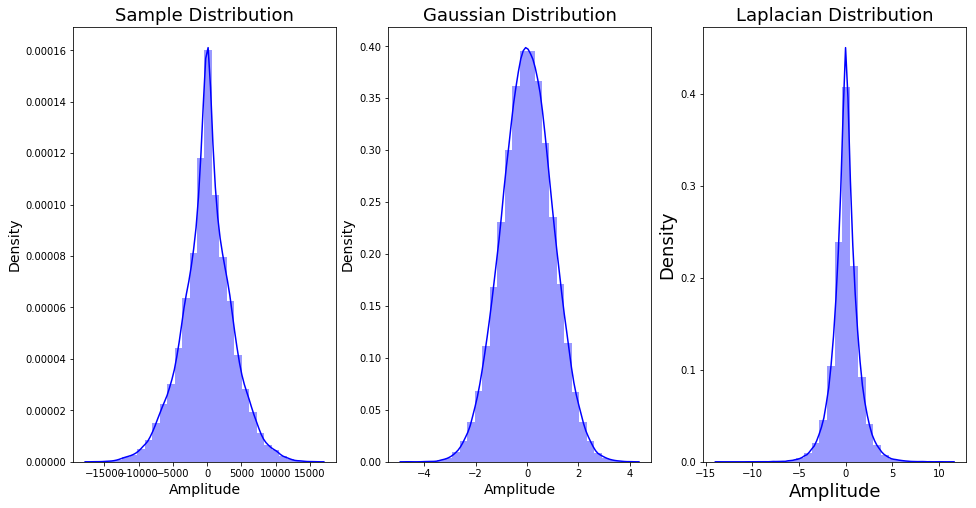

In [9]:
check_gaussianity(bach_sample)

## Test Speech Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = 15.9990  Kurtosis = 84.8716
Gaussian Distribution Skew = -1.1477  Kurtosis = 1.8021
Laplacian Distribution Skew = 0.1044  Kurtosis = 97.6179



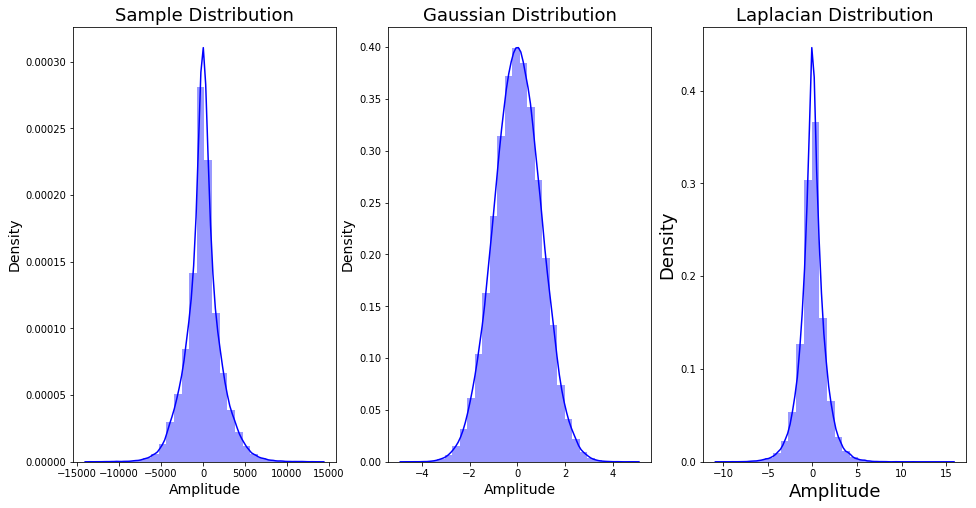

In [10]:
check_gaussianity(speech_sample)

## Mix Bach and Speech Samples

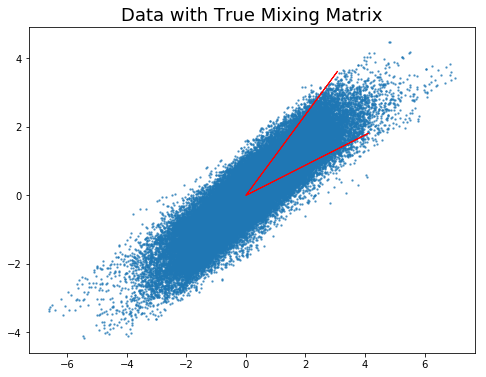

In [60]:
samples = audionorm([bach_sample, speech_sample])

# Standardize samples
samples = (samples.T / samples.std(axis=1)).T
X, true_A = simpleMixer(samples)

drawDataWithMixingMatrix(X, true_A)

## Visualize Samples and Mixed Signal

In [12]:
def plot_samples_mixed(samples, signal):
    # Independent Samples
    plt.figure(figsize=(8, 6))
    plt.plot(samples[0, :], label = 'Sample 1')
    plt.plot(samples[1, :], label = 'Sample 2')
    plt.legend()
    plt.title('Samples', size = 18)
    plt.show(); 
    
    # Mixed signal
    plt.figure(figsize=(8, 6))
    plt.plot(signal[0, :], alpha = 1.0, label = 'Mixed 1')
    plt.plot(signal[1, :], alpha = 1.0, label = 'Mixed 2')
    plt.legend()
    plt.title('Mixed Signal', size = 18)
    plt.show();

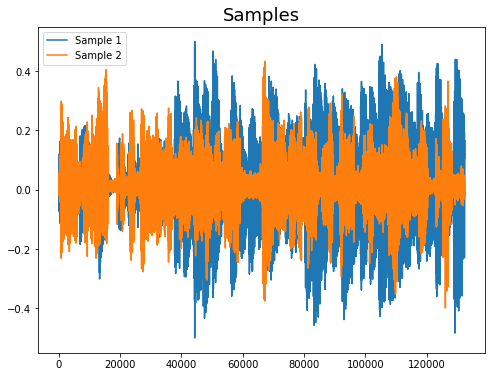

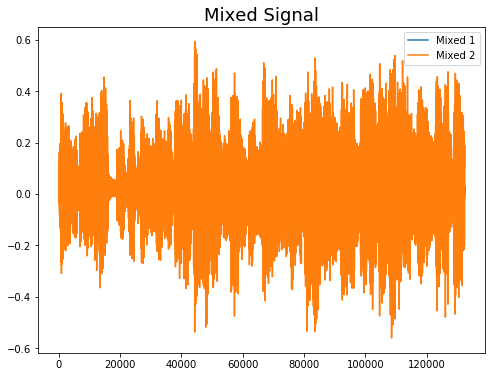

In [13]:
plot_samples_mixed(samples, X)

# Verify ICA Implementation

## Generate Synthetic Laplacian Data

In [14]:
# Generate a mixed signal for a number of samples and
# defined mixing matrix
def generate_laplacian_data(n_samples, mixing):
    # Set seed for reproducible results
    np.random.seed(seed = 50)
    
    # Laplacian distributions
    s1 = np.random.laplace(size = n_samples)
    s2 = np.random.laplace(size = n_samples)
    
    # Combine into one array
    S = np.array([s1, s2])
    
    # Mix samples
    generated_data = mixing.dot(S)
    
    return generated_data, S

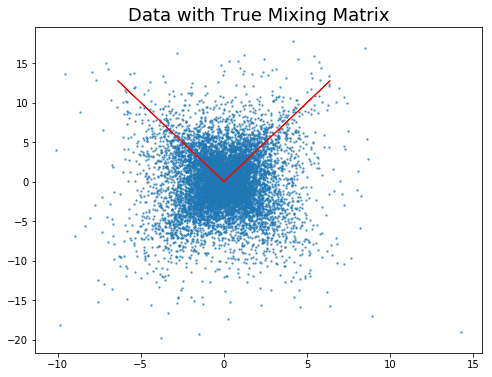

In [15]:
# Defined mixing matrix
verify_mixing = np.array([[-1, 1],
                          [2, 2]])

# Signal for verification
verify_signal, verify_samples = generate_laplacian_data(n_samples = 10000, mixing = verify_mixing)

# Visualize the verification data
drawDataWithMixingMatrix(verify_signal, verify_mixing)

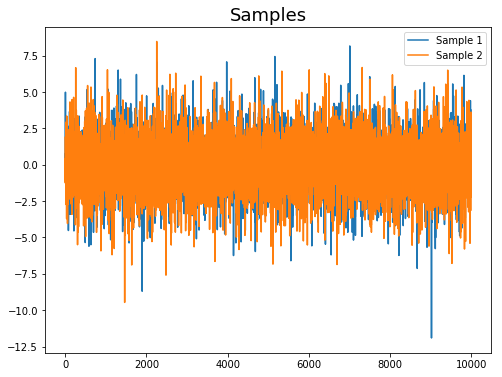

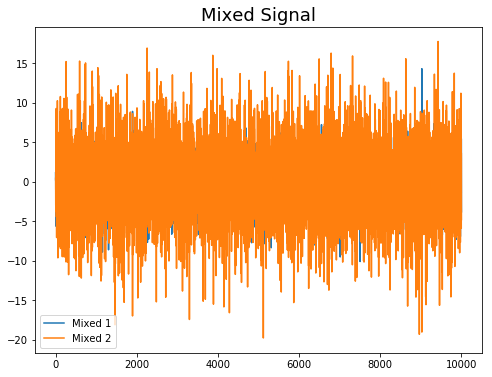

In [16]:
plot_samples_mixed(verify_samples, verify_signal)

### Implement ICA

In [17]:
# Use developed implementation of ICA, signal must be transposed
mixing, sources, mean = perform_fastica(verify_signal.T, n_components = 2, print_negentropy=True)

Yes
Iteration: 0 Increase in Negentropy: 0.0254.
Iteration: 1 Increase in Negentropy: 0.0401.
Iteration: 2 Increase in Negentropy: 0.0046.
Iteration: 3 Increase in Negentropy: 0.0000.


## Examine Estimated Mixing Matrix

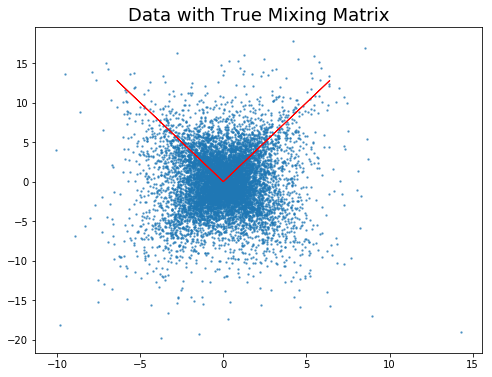

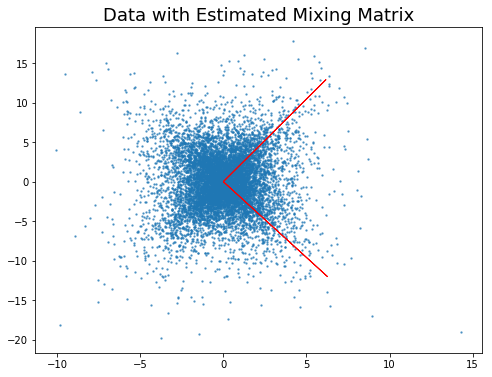

In [26]:
compareMixingMatrix(verify_signal, verify_mixing, mixing)

In [28]:
print('True Mixing Matrix\n')
print(verify_mixing)
print('\nEstimated Mixing Matrix\n')
print(mixing)

True Mixing Matrix

[[-1  1]
 [ 2  2]]

Estimated Mixing Matrix

[[ 138.35611608  140.36789838]
 [ 289.38993558 -269.30542947]]


## Examine Estimated Sources

In [22]:
def plot_samples_estimates(samples, estimates):
    # Independent Samples
    plt.figure(figsize=(8, 6))
    plt.plot(samples[0, :], label = 'Sample 1')
    plt.plot(samples[1, :], label = 'Sample 2')
    plt.legend()
    plt.title('Ground Truth Samples', size = 18)
    plt.show(); 
    
    # Mixed signal
    plt.figure(figsize=(8, 6))
    plt.plot(estimates[0, :], alpha = 1.0, label = 'Mixed 1')
    plt.plot(estimates[1, :], alpha = 1.0, label = 'Mixed 2')
    plt.legend()
    plt.title('Estimated Samples', size = 18)
    plt.show();

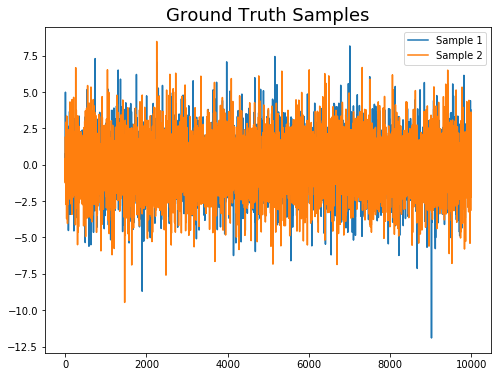

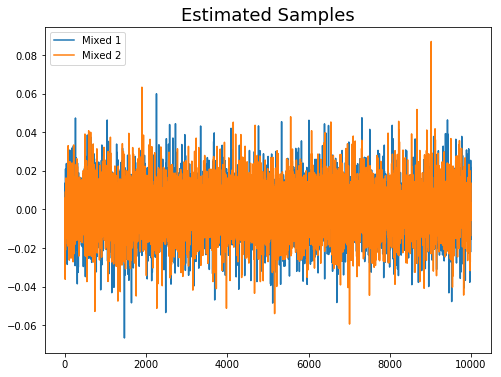

In [23]:
plot_samples_estimates(verify_samples, sources.T)

# Test Independent Component Implementation on Audio Data

In [24]:
audio_mixing, audio_sources, audio_mean = perform_fastica(X.T, n_components=2, print_negentropy=True)

Yes
Iteration: 0 Increase in Negentropy: 0.0440.
Iteration: 1 Increase in Negentropy: 0.0004.
Iteration: 2 Increase in Negentropy: 0.0000.


## Visualize Actual and Estimated Mixing Matrices

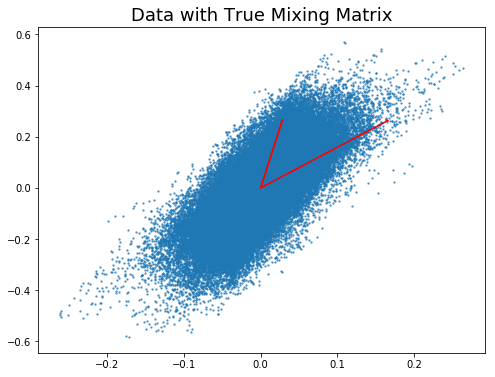

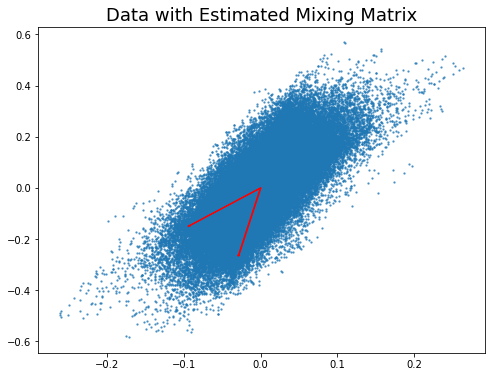

In [25]:
compareMixingMatrix(X, true_A, audio_mixing)

In [29]:
print('True Mixing Matrix\n')
print(true_A)
print('\nEstimated Mixing Matrix\n')
print(audio_mixing)

True Mixing Matrix

[[0.10479044 0.61264716]
 [0.98097189 0.97358785]]

Estimated Mixing Matrix

[[ -4.37740586 -14.17541972]
 [-40.25786404 -22.55879959]]


## Visualize Actual and Estimated Sources

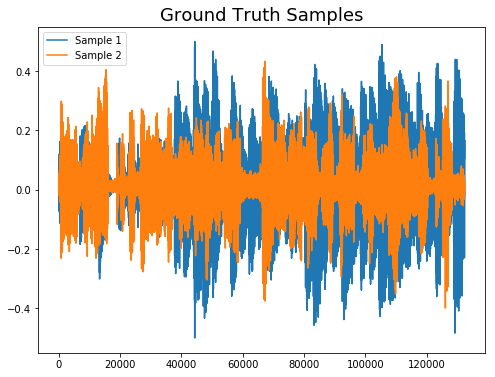

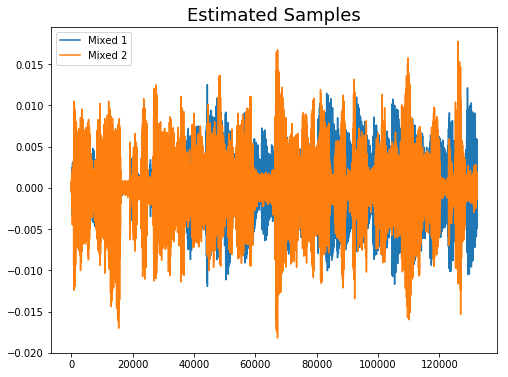

In [30]:
plot_samples_estimates(samples, audio_sources.T)

# Reconstruct Original Signal

In [31]:
np.allclose(np.dot(audio_mixing, audio_sources.T) + audio_mean, X)

ValueError: operands could not be broadcast together with shapes (2,132362) (2,) 

In [47]:
samples /= 

ValueError: operands could not be broadcast together with shapes (2,132362) (2,) (2,132362) 

array([0.11238831, 0.06358098])

In [52]:
X = (samples.T / samples.std(axis=1)).T

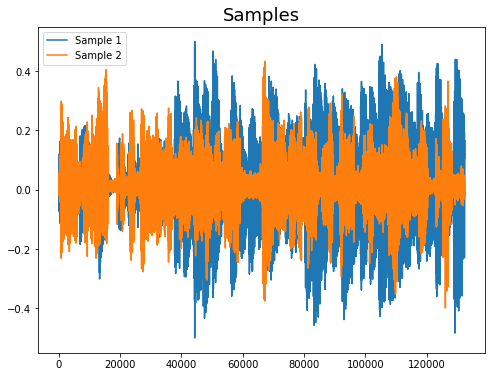

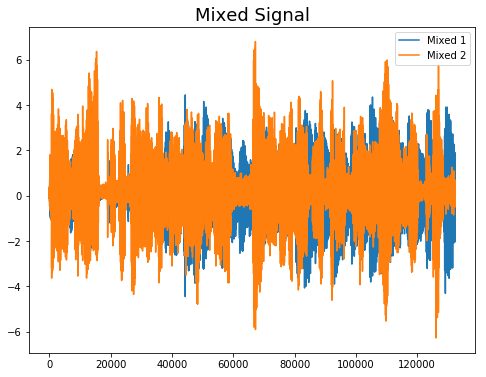

In [54]:
plot_samples_mixed(samples, X)